# Import Libraries


In [1]:
import os
from zipfile import ZipFile
import torch
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification, AdamW, get_scheduler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import LSTM, GRU, Bidirectional, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import pandas as pd
from datasets import Dataset, load_dataset, load_metric

from copy import deepcopy




2024-06-25 08:54:43.051880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 08:54:43.051987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 08:54:43.223809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Clone GitHub Repository

In [3]:
!git clone https://github.com/Ragini164/Punjabi-Poet-Attribution.git

fatal: destination path 'Punjabi-Poet-Attribution' already exists and is not an empty directory.


In [3]:
# !rm -r "/kaggle/working/Punjabi-Poet-Attribution/Datasets/Roman/Ustad Daman"
# !rm -r "/kaggle/working/Punjabi-Poet-Attribution/Datasets/Roman/Bulle Shah"
# !rm -r "/kaggle/working/Punjabi-Poet-Attribution/Datasets/Roman/Bhai Vir Singh"

# Load Dataset

In [5]:
root_folder_path = '/kaggle/working/Punjabi-Poet-Attribution/Datasets/Gurmukhi/'  # Adjust to the actual folder name after extraction

# Get a list of poet folders
poet_folders = [folder for folder in os.listdir(root_folder_path) if os.path.isdir(os.path.join(root_folder_path, folder))]

# # Initialize empty lists to store poems and labels
poems1 = []
labels = []

# # Read poems and assign labels based on folder names

for label, poet_folder in enumerate(poet_folders):
    print(poet_folder)
    poet_folder_path = os.path.join(root_folder_path, poet_folder)

    # Assuming each text file in the poet's folder contains a poem
    poem_files = [file for file in os.listdir(poet_folder_path) if file.endswith('.txt')]
#     print(poem_files)

    for poem_file in poem_files:
        poem_file_path = os.path.join(poet_folder_path, poem_file)

        with open(poem_file_path, 'r', encoding='utf-8') as file:
            poem_text = file.read()

        poems1.append(poem_text)
        labels.append(poet_folder)

poems = [entry.replace('\t', '').replace('\n\n', '\n') for entry in poems1]

print(len(labels),len(poems))

Sultan Bahu
Bhai Vir Singh
Baba Bulle Shah
Baba Farid
Ustad Daman
Fazal Shah
Shah Muhammad
Waris Shah
1491 1491


In [6]:
!rm -r /kaggle/working/TrainTestSplit
!mkdir /kaggle/working/TrainTestSplit
!mkdir /kaggle/working/TrainTestSplit/Train
!mkdir /kaggle/working/TrainTestSplit/Test
!mkdir /kaggle/working/TrainTestSplit/Validation

rm: cannot remove '/kaggle/working/TrainTestSplit': No such file or directory


# Train Test Validation Split

In [7]:
save_path = "/kaggle/working/TrainTestSplit"

In [8]:
#BERT EMBEDDINGS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Split the dataset into training and testing sets
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

poems_train, poems_temp, labels_train, labels_temp = train_test_split(poems, encoded_labels, test_size=0.2, random_state=42)
poems_val, poems_test, labels_val, labels_test = train_test_split(poems_temp, labels_temp, test_size=0.5, random_state=42)

# Load the tokenizer and model (using DistilBERT)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')



# Save training embeddings
for i, poem_text in enumerate(poems_train):
    # Tokenize and encode the poem
    poem_batch_dict = tokenizer(poem_text, padding=True, truncation=True, return_tensors='pt', max_length=80)

    # Generate the embedding
    poem_output = model(**poem_batch_dict)
    poem_embedding = poem_output.last_hidden_state.mean(dim=1).to(device)

    # Save the embedding
    torch.save(poem_embedding, f'{save_path}/Train/train_embedding_{i}.pt')

# Save validation embeddings
for i, poem_text in enumerate(poems_val):
    # Tokenize and encode the poem
    poem_batch_dict = tokenizer(poem_text, padding=True, truncation=True, return_tensors='pt', max_length=80)

    # Generate the embedding
    poem_output = model(**poem_batch_dict)
    poem_embedding = poem_output.last_hidden_state.mean(dim=1).to(device)

    # Save the embedding
    torch.save(poem_embedding, f'{save_path}/Validation/val_embedding_{i}.pt')

# Save test embeddings
for i, poem_text in enumerate(poems_test):
    # Tokenize and encode the poem
    poem_batch_dict = tokenizer(poem_text, padding=True, truncation=True, return_tensors='pt', max_length=80)

    # Generate the embedding
    poem_output = model(**poem_batch_dict)
    poem_embedding = poem_output.last_hidden_state.mean(dim=1).to(device)

    # Save the embedding
    torch.save(poem_embedding, f'{save_path}/Test/test_embedding_{i}.pt')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

In [9]:
class_labels = sorted(list(set(labels_train)))
# Assuming you've already loaded and preprocessed your data
# Load the saved embeddings
def load_embeddings(prefix, num_embeddings):
    embeddings = []
    for i in range(num_embeddings):
        file_path = f'{prefix}_{i}.pt'
        embedding = torch.load(file_path)
        embeddings.append(embedding)
    return torch.stack(embeddings)

train_embeddings = load_embeddings(f'{save_path}/Train/train_embedding', len(poems_train))
val_embeddings = load_embeddings(f'{save_path}/Validation/val_embedding', len(poems_val))
test_embeddings = load_embeddings(f'{save_path}/Test/test_embedding', len(poems_test))

# Convert labels to PyTorch tensors
train_labels = torch.tensor(labels_train)
val_labels = torch.tensor(labels_val)
test_labels = torch.tensor(labels_test)

# Encode labels


train_embeddings_np = train_embeddings.detach().cpu().numpy()
val_embeddings_np = val_embeddings.detach().cpu().numpy()
test_embeddings_np = test_embeddings.detach().cpu().numpy()
labels_train_np = np.array(labels_train)
labels_val_np = np.array(labels_val)
labels_test_np = np.array(labels_test)

In [10]:
train_embeddings_np.shape, labels_train_np.shape, val_embeddings_np.shape, labels_val_np.shape, test_embeddings_np.shape, labels_test_np.shape

((1192, 1, 768), (1192,), (149, 1, 768), (149,), (150, 1, 768), (150,))

# LSTM Model

Epoch 1/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2301 - loss: 1.9933 - val_accuracy: 0.4516 - val_loss: 1.6287
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5507 - loss: 1.4601 - val_accuracy: 0.7527 - val_loss: 1.1116
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7296 - loss: 1.0057 - val_accuracy: 0.7204 - val_loss: 0.8499
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8053 - loss: 0.7702 - val_accuracy: 0.7849 - val_loss: 0.7260
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8352 - loss: 0.6339 - val_accuracy: 0.7957 - val_loss: 0.6480
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8788 - loss: 0.5307 - val_accuracy: 0.8280 - val_loss: 0.5644
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8463 - loss: 0.4713 - val_accuracy: 0.8602 - val_loss: 0.5096
Epoch 8/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8937 - loss: 0.4351 - val_accuracy: 0.8495 - val_loss

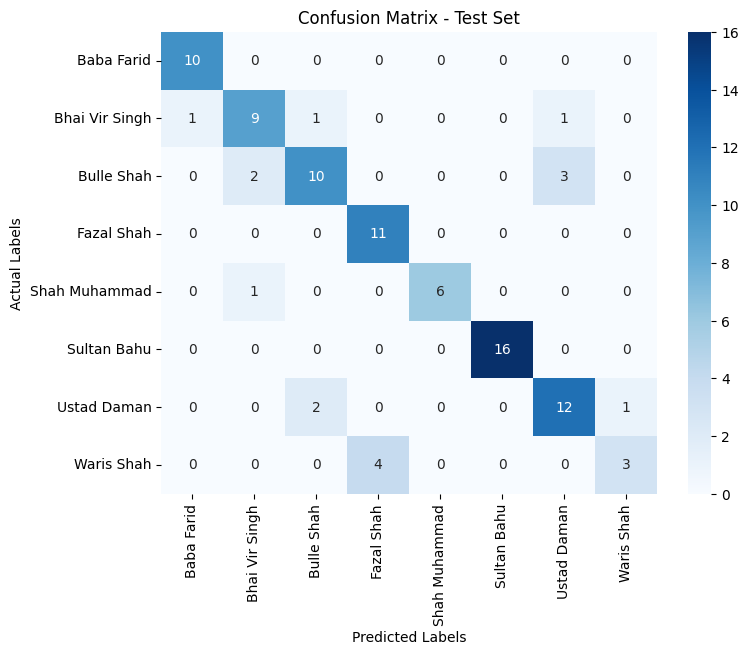

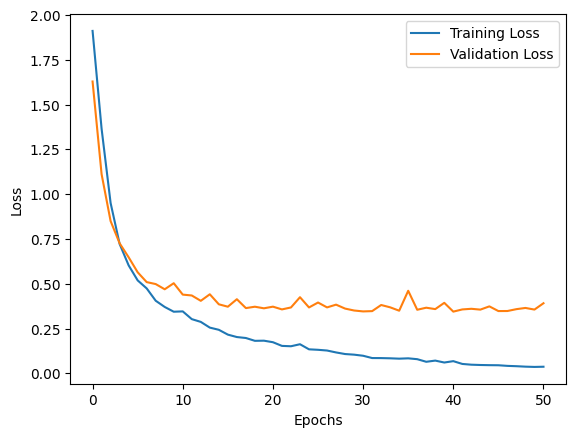

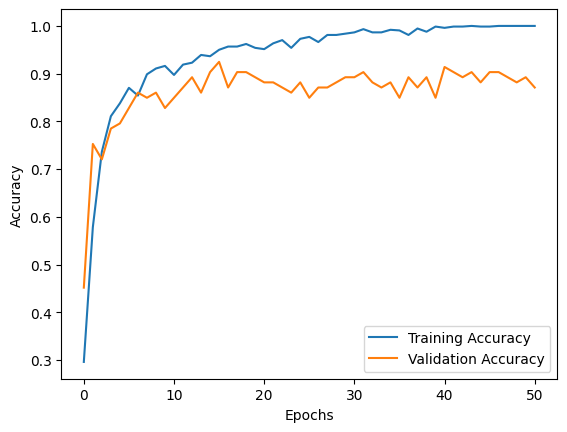

In [9]:
model = Sequential()
# model.add(Embedding(input_dim=len(vocab) + 1, output_dim=50, input_length=max_seq_length))
model.add(Bidirectional(LSTM(30)))
model.add(Dense(len(set(encoded_labels)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(train_embeddings_np, labels_train_np, validation_data=(val_embeddings_np, labels_val_np),
                    epochs=80, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on the test set
# Evaluate the model on the test set
test_probabilities = model.predict(test_embeddings_np)
test_predictions = np.argmax(test_probabilities, axis=1)
test_accuracy = accuracy_score(labels_test_np, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(labels_test_np, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# GRU Model

Epoch 1/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2313 - loss: 1.9680 - val_accuracy: 0.4624 - val_loss: 1.5183
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5205 - loss: 1.3867 - val_accuracy: 0.7097 - val_loss: 1.0584
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6929 - loss: 0.9773 - val_accuracy: 0.7419 - val_loss: 0.8666
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7927 - loss: 0.7444 - val_accuracy: 0.8172 - val_loss: 0.7190
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8449 - loss: 0.6259 - val_accuracy: 0.8065 - val_loss: 0.6471
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8302 - loss: 0.5404 - val_accuracy: 0.7957 - val_loss: 0.6342
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8630 - loss: 0.4813 - val_accuracy: 0.8710 - val_loss: 0.5325
Epoch 8/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8629 - loss: 0.4517 - val_accuracy: 0.8280 - val_loss

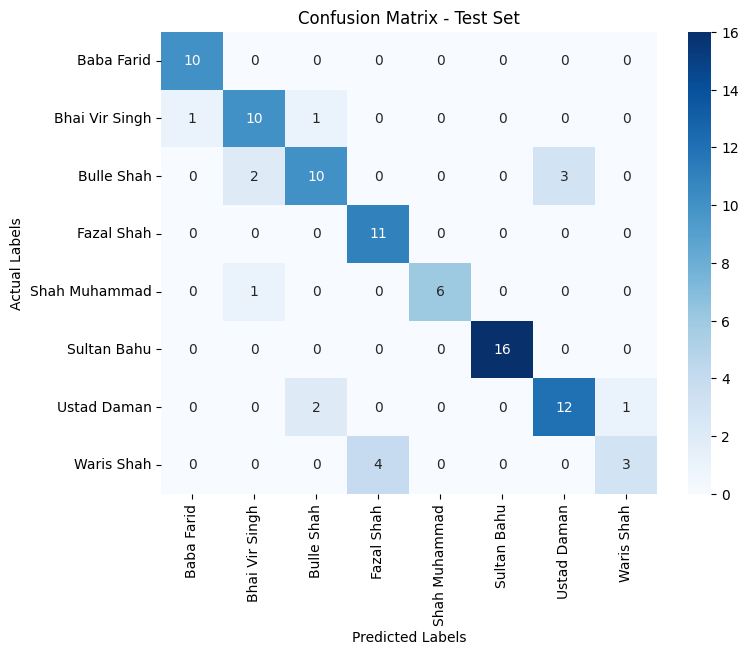

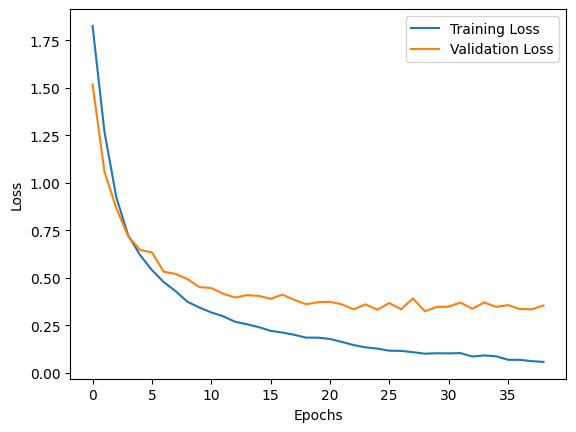

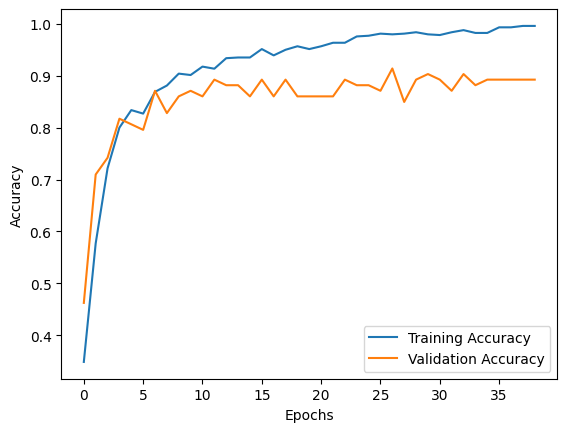

In [10]:
# Define the Keras GRU model
model = Sequential()
model.add(Bidirectional(GRU(30)))
model.add(Dense(len(set(encoded_labels)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(train_embeddings_np, labels_train_np, validation_data=(val_embeddings_np, labels_val_np),
                    epochs=80, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on the test set
test_probabilities = model.predict(test_embeddings_np)
test_predictions = np.argmax(test_probabilities, axis=1)
test_accuracy = accuracy_score(labels_test_np, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(labels_test_np, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# BERT Embeddings

In [11]:
train_df = pd.DataFrame({'text': poems_train, 'labels': labels_train_np })
test_df = pd.DataFrame({'text': poems_test, 'labels': labels_test_np})
val_df = pd.DataFrame({'text': poems_val, 'labels': labels_val_np})

In [12]:
train_df.shape, test_df.shape, val_df.shape

((1192, 2), (150, 2), (149, 2))

In [13]:
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)


In [14]:
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, max_length=80,padding='max_length')


train_tokenized_datasets = train_dataset.map(tokenize_function, batched=True)
validation_tokenized_datasets = validation_dataset.map(tokenize_function, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_function, batched=True)

train_tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
validation_tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/1192 [00:00<?, ? examples/s]

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [15]:
checkpoint = 'distilbert-base-multilingual-cased'
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint,num_labels=len(set(encoded_labels)))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [16]:
torch.cuda.empty_cache()


In [17]:
# Create DataLoader
train_dataloader = DataLoader(train_tokenized_datasets, shuffle=True, batch_size=32)
test_dataloader = DataLoader(test_tokenized_datasets, batch_size=32)
val_dataloader = DataLoader(validation_tokenized_datasets, batch_size=32)

# Load model

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Setup learning rate scheduler
num_epochs = 100
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Initialize metric
accuracy_metric = load_metric("accuracy")

# Training and validation loop
progress_bar = tqdm(range(num_training_steps))

val_accuracies = []
train_accuracies = []
best_val_loss = float('inf')
patience = 5  # You can adjust this based on your needs
counter = 0
train_losses = []  # Track training loss
val_losses = []


for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    accuracy_metric = load_metric("accuracy")
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.item()
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
        
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = accuracy_metric.compute()["accuracy"]

    # Validation
    model.eval()
    val_loss = 0
    accuracy_metric = load_metric("accuracy")

    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        val_loss += loss.item()

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = accuracy_metric.compute()["accuracy"]
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    val_losses.append(avg_val_loss)
    train_losses.append(avg_train_loss)


    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    if counter >= patience:
        print("Early stopping triggered!")
        break




/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_34/3266192163.py:22: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trus

  0%|          | 0/3800 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch 1/100
Training Loss: 1.3133
Training Accuracy: 0.5537
Validation Loss: 0.6696
Validation Accuracy: 0.7785


/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch 2/100
Training Loss: 0.4326
Training Accuracy: 0.8591
Validation Loss: 0.3547
Validation Accuracy: 0.8725


/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch 3/100
Training Loss: 0.2406
Training Accuracy: 0.9128
Validation Loss: 0.3351
Validation Accuracy: 0.8523


/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch 4/100
Training Loss: 0.2219
Training Accuracy: 0.9228
Validation Loss: 0.3624
Validation Accuracy: 0.8859


/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch 5/100
Training Loss: 0.1783
Training Accuracy: 0.9371
Validation Loss: 0.2049
Validation Accuracy: 0.9262


/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch 6/100
Training Loss: 0.1197
Training Accuracy: 0.9589
Validation Loss: 0.1660
Validation Accuracy: 0.9329


/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch 7/100
Training Loss: 0.0818
Training Accuracy: 0.9765
Validation Loss: 0.1925
Validation Accuracy: 0.9530


/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch 8/100
Training Loss: 0.0747
Training Accuracy: 0.9782
Validation Loss: 0.4141
Validation Accuracy: 0.8523


/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch 9/100
Training Loss: 0.0517
Training Accuracy: 0.9832
Validation Loss: 0.2617
Validation Accuracy: 0.9329


/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch 10/100
Training Loss: 0.0331
Training Accuracy: 0.9933
Validation Loss: 0.3160
Validation Accuracy: 0.9128


/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch 11/100
Training Loss: 0.0372
Training Accuracy: 0.9908
Validation Loss: 0.3217
Validation Accuracy: 0.9128
Early stopping triggered!


Test Accuracy: 0.9533


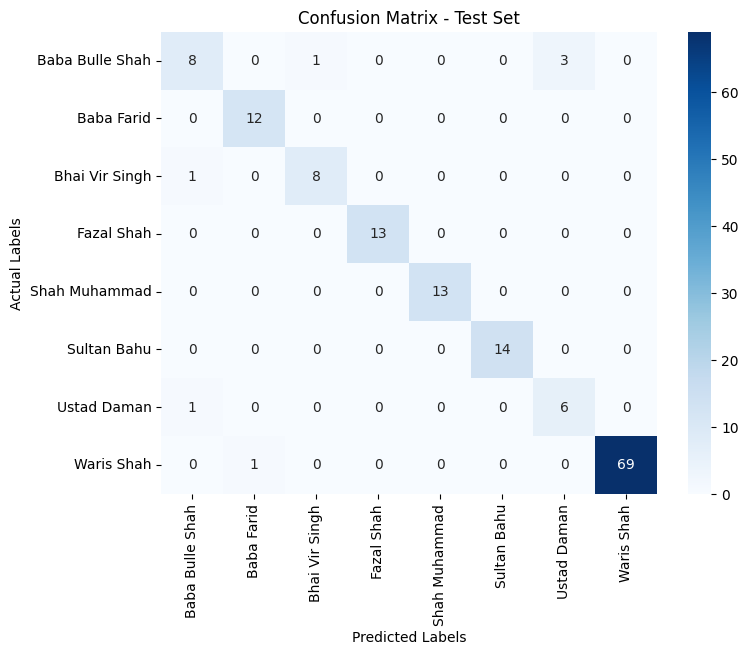

In [18]:
# Plot the confusion matrix
# Get predictions for the confusion matrix
# test_predictions = trainer.predict(test_tokenized_datasets)

model.eval()

all_predictions = []
all_labels = []

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
    
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())

final_score = accuracy_metric.compute()
print(f"Test Accuracy: {final_score['accuracy']:.4f}")



test_predicted_labels = predictions.argmax(-1)

cm = confusion_matrix(all_predictions, all_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()



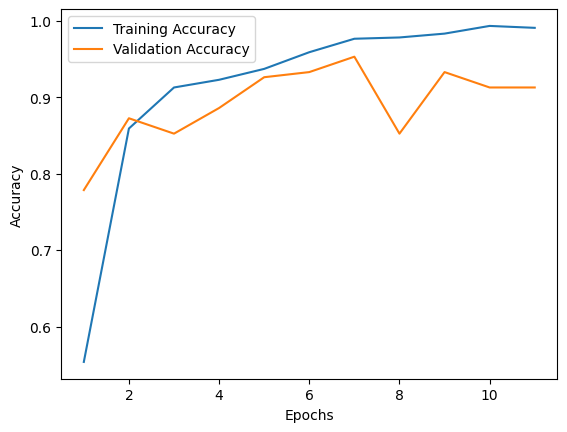

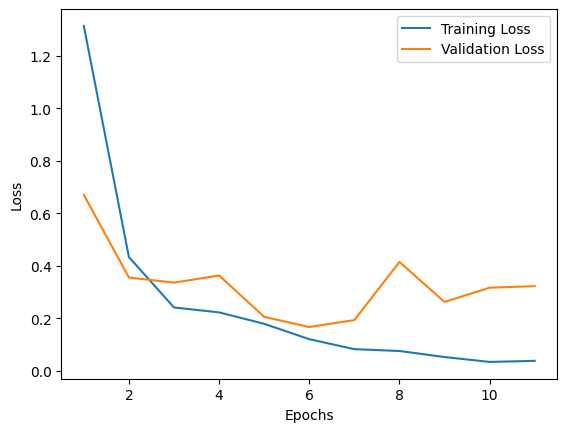

In [19]:

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
# plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plt.tight_layout()
plt.show()
 